## 止盈止损-TrailingStopLoss
1. 最高价吊灯(highPrice)
2. 波幅吊灯(atrMultiple)
3. 价格百分比跟踪(stairPct)
4. 指标追踪(Indicator)

### 1. 最高价吊灯(highPrice)
适用于日内交易：
1. 设置追踪止损的百分比
2. 创建记录最高最低价的字典并把初始值设置成0与一个极大数值
3. 记录不断创新高或新低的价格
4. 当现价超过最(高/低)价加减追踪止损的百分比的比例即出场

In [ ]:
# 设置参数
trailingPct = 0.02 #百分之二

# 设置变量
self.intraTradeHighDict = {s: 0 for s in self.symbolList}
self.intraTradeLowDict = {s: 999999 for s in self.symbolList}

# 变量初始化
if self.posDict[symbol + "_LONG"] == 0 and self.posDict[symbol + "_SHORT"] == 0:
    self.intraTradeHighDict[symbol] = 0
    self.intraTradeLowDict[symbol] = 999999

# 持有多头仓位
elif self.posDict[symbol + "_LONG"] > 0:
    self.intraTradeHighDict[symbol] = max(self.intraTradeHighDict[symbol], bar.high)
    longStop = self.intraTradeHighDict[symbol] * (1-self.trailingPct)
    if bar.low <= longStop:
        self.sell(symbol, bar.close * 0.985, self.posDict[symbol + "_LONG"])

# 持有空头仓位
elif self.posDict[symbol + "_SHORT"] > 0:
    self.intraTradeLowDict[symbol] = min(self.intraTradeLowDict[symbol], bar.low)
    shortStop = self.intraTradeLowDict[symbol] * (1 + self.trailingPct)
    if bar.high >= shortStop:
        self.cover(symbol, bar.close * 1.015, self.posDict[symbol + "_SHORT"])

### 2. 波幅吊灯(atrMultiple)
适用于日内交易：
1. 设置ATR的倍数，并计算ATR的值。
2. 创建记录最高最低价的字典并把初始值设置成0与一个极大数值
3. 记录不断创新高或新低的价格
4. 当现价超过最(高/低)价加减ATR的倍数即出场，记录止损价，只能提升浮盈。

In [ ]:
# 设置参数
atrMultipler = 3 #3倍的ATR

# 设置变量
self.intraTradeHighDict = {s: 0 for s in self.symbolList}
self.intraTradeLowDict = {s: 999999 for s in self.symbolList}

# 计算ATR的值
atr = ta.ATR(am.close, 10)

# 变量初始化
if self.posDict[symbol + "_LONG"] == 0 and self.posDict[symbol + "_SHORT"] == 0:
    self.intraTradeHighDict[symbol] = 0
    self.intraTradeLowDict[symbol] = 999999
    self.longStop[symbol] = 0
    self.shortStop[symbol] = 999999

# 持有多头仓位
elif self.posDict[symbol + "_LONG"] > 0:
    self.intraTradeHighDict[symbol] = max(self.intraTradeHighDict[symbol], bar.high)
    self.longStop[symbol] = max(self.longStop[symbol], self.intraTradeHighDict[symbol]-self.atrMultipler*self.atr)
    if bar.low <= self.longStop[symbol]:
        self.sell(symbol, bar.close * 0.985, self.posDict[symbol + "_LONG"])

# 持有空头仓位
elif self.posDict[symbol + "_SHORT"] > 0:
    self.intraTradeLowDict[symbol] = min(self.intraTradeLowDict[symbol], bar.low)
    self.shortStop[symbol] = min(self.shortStop[symbol], self.intraTradeLowDict[symbol]+self.atrMultipler*self.atr)
    if bar.high >= self.shortStop[symbol]:
        self.cover(symbol, bar.close * 1.015, self.posDict[symbol + "_SHORT"])

## 3. 价格百分比跟踪(stairPct)
适用于隔夜交易：
1. 设置追踪止损的百分比
2. 创建记录最高最低价的字典并把初始值设置成0与一个极大数值
3. 记录不断创新高或新低的价格
4. 当最(高/低)价加减追踪止损百分比超过一定比例，止损才会移动
5. 当现价超过止损即出场

In [ ]:
# 设置参数
trailingPct = 0.02 #百分之二

# 设置变量
self.intraTradeHighDict = {s: 0 for s in self.symbolList}
self.intraTradeLowDict = {s: 999999 for s in self.symbolList}

# 变量初始化
if self.posDict[symbol + "_LONG"] == 0 and self.posDict[symbol + "_SHORT"] == 0:
    self.intraTradeHighDict[symbol] = 0
    self.intraTradeLowDict[symbol] = 999999
    self.nChange = 0

# 持有多头仓位
elif self.posDict[symbol + "_LONG"] > 0:
    self.intraTradeHighDict[symbol] = max(self.intraTradeHighDict[symbol], bar.high)
    self.nChange = (self.intraTradeHighDict[symbol]/transactionPrice[symbol]-1)//self.trailingPct
    changePrice = transactionPrice[symbol]*self.nChange*self.trailingPct
    self.longStop[symbol] = max(self.longStop[symbol], transactionPrice[symbol]*(1-self.trailingPct)+changePrice)
    if bar.low <= self.longStop[symbol]:
        self.sell(symbol, bar.close * 0.985, self.posDict[symbol + "_LONG"])

# 持有空头仓位
elif self.posDict[symbol + "_SHORT"] > 0:
    self.intraTradeLowDict[symbol] = min(self.intraTradeLowDict[symbol], bar.low)
    self.nChange[symbol] = -1* (self.intraTradeLowDict[symbol]/self.transactionPrice[symbol]-1)//self.trailingPct
    changePrice = self.transactionPrice[symbol]*self.nChange[symbol]*self.trailingPct
    self.shortStop[symbol] = min(self.shortStop[symbol], self.transactionPrice[symbol]*(1+self.trailingPct)-changePrice)
    if bar.high >= self.shortStop[symbol]:
        self.cover(symbol, bar.close * 1.015, self.posDict[symbol + "_SHORT"])
        self.stopLossControl[symbol] = -1

### 4. 指标追踪止损(Indicator)
适合信号出场：
1. 设定指标参数
2. 多空出场信号

In [ ]:
# 设置参数
kamaPeriod = 20

# 计算指标
kama = ta.KAMA(am.close, self.kamaPeriod)

# 持有多头仓位
if self.posDict[symbol + "_LONG"] > 0:
    if bar.close<=kama[-1]:
        self.sell(symbol, bar.close * 0.985, self.posDict[symbol + "_LONG"])
# 持有空头仓位
if self.posDict[symbol + "_SHORT"] > 0:
    if bar.close>=kama[-1]:
        self.cover(symbol, bar.close * 1.015, self.posDict[symbol + "_SHORT"])

In [ ]:
# 设置参数
sarPeriod = 20

# 计算指标
sar = ta.SAR(am.close, self.kamaPeriod)

# 持有多头仓位
if self.posDict[symbol + "_LONG"] > 0:
    if bar.close<=sar[-1] and bar.close>=sar[-2]:
        self.sell(symbol, bar.close * 0.985, self.posDict[symbol + "_LONG"])

# 持有空头仓位
if self.posDict[symbol + "_SHORT"] > 0:
    if bar.close<=sar[-1] and bar.close>=sar[-2]:
        self.cover(symbol, bar.close * 1.015, self.posDict[symbol + "_SHORT"])

### Example: stairPctCase
1. 设置参数
2. 添加stairPct模块到onBar

In [19]:
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate
import talib as ta

########################################################################
# 策略继承CtaTemplate
class MultiFrameMaStrategy(CtaTemplate):
    className = 'MultiFrameMaStrategy'
    author = 'ChannelCMT'
    
    # 策略参数
    fastPeriod = 20; slowPeriod = 40
    signalMaPeriod = 20
    trailingPct = 0.04 #百分之二
    lot = 1
    
    # 策略变量
    maTrend = {} # 记录趋势状态，多头1，空头-1
    transactionPrice = {} # 记录成交价格
    
    # 参数列表，保存了参数的名称
    paramList = [
                 'fastPeriod',
                 'slowPeriod',
                 'signalMaPeriod',
                 'stopRatio'
                ]    
    
    # 变量列表，保存了变量的名称
    varList = [
               'maTrend',
               'transactionPrice'
              ]  
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        super().__init__(ctaEngine, setting)
    
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略"""
        self.writeCtaLog(u'策略初始化')
        self.transactionPrice = {s:0 for s in self.symbolList} # 生成成交价格的字典
        self.maTrend = {s:0 for s in self.symbolList}
        self.intraTradeHighDict = {s: 0 for s in self.symbolList}
        self.intraTradeLowDict = {s: 999999 for s in self.symbolList}
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略"""
        self.writeCtaLog(u'策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        pass
    
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送"""
        self.onBarStopLoss(bar)

    def onBarStopLoss(self, bar):
        symbol = bar.vtSymbol

        # 变量初始化
        if self.posDict[symbol + "_LONG"] == 0 and self.posDict[symbol + "_SHORT"] == 0:
            self.intraTradeHighDict[symbol] = 0
            self.intraTradeLowDict[symbol] = 999999

        # 持有多头仓位
        elif self.posDict[symbol + "_LONG"] > 0:
            self.intraTradeHighDict[symbol] = max(self.intraTradeHighDict[symbol], bar.high)
            longStop = self.intraTradeHighDict[symbol] * (1-self.trailingPct)
            if bar.low <= longStop:
#                 print('longStop')
                self.cancelAll()
                self.sell(symbol, bar.close * 0.99, self.posDict[symbol + "_LONG"])

        # 持有空头仓位
        elif self.posDict[symbol + "_SHORT"] > 0:
            self.intraTradeLowDict[symbol] = min(self.intraTradeLowDict[symbol], bar.low)
            shortStop = self.intraTradeLowDict[symbol] * (1 + self.trailingPct)
            if bar.high >= shortStop:
#                 print('shortStop')
                self.cancelAll()
                self.cover(symbol, bar.close * 1.01, self.posDict[symbol + "_SHORT"])
    #----------------------------------------------------------------------
    def on60MinBar(self, bar):
        """收到60MinBar推送"""
        symbol = bar.vtSymbol
        
        am60 = self.getArrayManager(symbol, "60m")
        
        if not am60.inited:
            return
        
        # 计算均线并判断趋势
        fastMa = ta.MA(am60.close, self.fastPeriod)
        slowMa = ta.MA(am60.close, self.slowPeriod)
        
        if fastMa[-1] > slowMa[-1]:
            self.maTrend[symbol] = 1
        else:
            self.maTrend[symbol] = -1
    
    #----------------------------------------------------------------------
    def on15MinBar(self, bar):
        """收到15MinBar推送"""
        symbol = bar.vtSymbol
        
        am15 = self.getArrayManager(symbol, "15m")
        
        if not am15.inited:
            return

        signalMa = ta.EMA(am15.close, self.signalMaPeriod)

        maUp = signalMa[-1]>signalMa[-3] # 均线上涨
        maDn = signalMa[-1]<signalMa[-3] # 均线下跌
        
        # 均线上涨， 趋势为多头， 多头没有持仓
        if maUp and (self.maTrend[symbol]==1) and (self.posDict[symbol+'_LONG']==0):
            if  (self.posDict[symbol+'_SHORT']==0):
                self.buy(symbol, bar.close*1.01, self.lot)  # 成交价*1.01发送高价位的限价单，以最优市价买入进场
            elif (self.posDict[symbol+'_SHORT'] > 0):
                self.cancelAll() # 撤销挂单
                self.cover(symbol, bar.close*1.01, self.posDict[symbol+'_SHORT']) 
                self.buy(symbol, bar.close*1.01, self.lot)
        
        # 均线下跌， 趋势为空头， 空头没有持仓
        if maDn and (self.maTrend[symbol]==-1) and (self.posDict[symbol+'_SHORT']==0):
            if (self.posDict[symbol+'_LONG']==0):
                self.short(symbol, bar.close*0.99, self.lot) # 成交价*0.99发送低价位的限价单，以最优市价卖出进场
            elif (self.posDict[symbol+'_LONG'] > 0):
                self.cancelAll() # 撤销挂单
                self.sell(symbol, bar.close*0.99, self.posDict[symbol+'_LONG'])
                self.short(symbol, bar.close*0.99, self.lot)
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送（必须由用户继承实现）"""
        symbol = trade.vtSymbol
        if trade.offset == OFFSET_OPEN:  # 判断成交订单类型
            self.transactionPrice[symbol] = trade.price # 记录成交价格
#         print(trade.tradeTime, self.posDict)
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass# 策略变量

In [20]:
from vnpy.trader.app.ctaStrategy import BacktestingEngine
import pandas as pd

def runBacktesting(strategyClass, settingDict,
                   startDate, endDate, slippage, rate):
    engine = BacktestingEngine()
    engine.setBacktestingMode(engine.BAR_MODE)  # 设置引擎的回测模式为K线
    engine.setDatabase('VnTrader_1Min_Db')    # 设置使用的历史数据库
    engine.setStartDate(startDate, initHours=200)   # 设置回测用的数据起始日期
    engine.setEndDate(endDate)     # 设置回测用的数据结束日期
    engine.setSlippage(slippage)    # 设置滑点
    engine.setRate(rate)             # 设置手续费万0.3
    engine.initStrategy(strategyClass, settingDict)
    engine.setCapital(100000)     # 设置回测本金
    engine.runBacktesting()
    #显示逐日回测结果
    engine.showDailyResult()
    #显示逐笔回测结果
    engine.showBacktestingResult()
    # 计算回测结果
    perfromance = engine.calculateDailyResult()
    perfromanceDf , result = engine.calculateDailyStatistics(perfromance)
    tradeReport = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])
    tradeDf = tradeReport.set_index('dt')
    return perfromanceDf, tradeDf

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameMaStrategy.on60MinBar at 0x0000016A0CFA8598>, <__main__.MultiFrameMaStrategy object at 0x0000016A0CFADCC0>)
[DEBUG] 注册品种BTCUSDT:binance上的on_15Min_bar函数functools.partial(<function MultiFrameMaStrategy.on15MinBar at 0x0000016A0CF5B048>, <__main__.MultiFrameMaStrategy object at 0x0000016A0CFADCC0>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameMaStrategy.onBar at 0x0000016A0CF5B730>, <__main__.MultiFrameMaStrategy object at 0x0000016A0CFADCC0>)
2018-11-27 19:01:08.879074	开始回测
2018-11-27 19:01:08.879074	策略初始化
2018-11-27 19:01:08.880074	载入历史数据。数据范围:[20180824 04:00,20180901 12:00)
2018-11-27 19:01:09.439500	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-11-27 19:01:09.444495	载入完成，数据量：12000
2018-11-27 19:01:09.444495	策略初始化完成
2018-11-27 19:01:09.444495	策略启动完成
2018-11-27 19:01:09.444495	开始回放回测数据,回测范围:[20180901 12:00,20

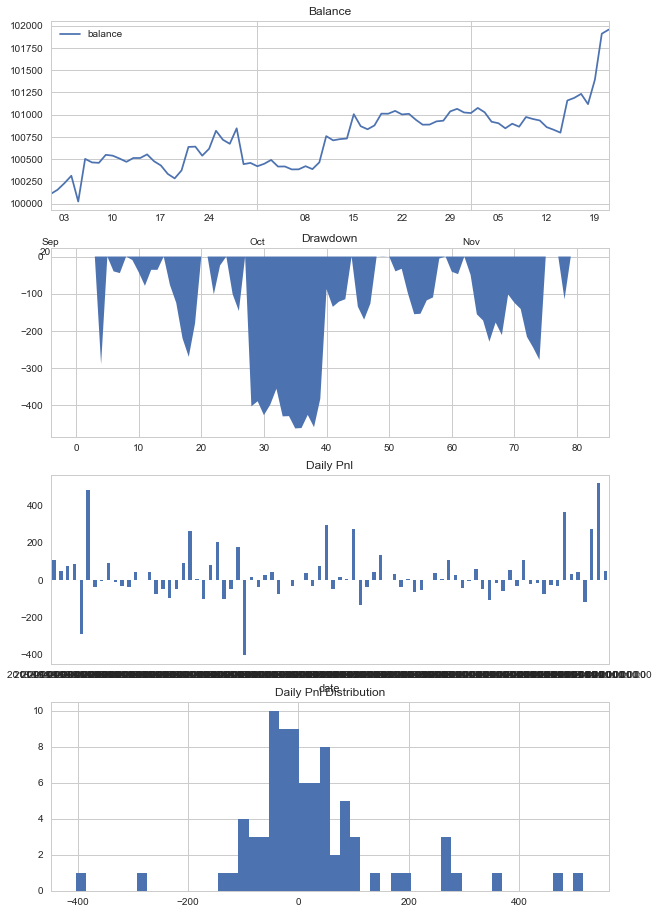

2018-11-27 19:01:29.331143	计算回测结果
2018-11-27 19:01:29.338136	------------------------------
2018-11-27 19:01:29.338136	第一笔交易：	2018-09-04 06:45:00
2018-11-27 19:01:29.338136	最后一笔交易：	2018-11-21 10:18:00
2018-11-27 19:01:29.338136	总交易次数：	76
2018-11-27 19:01:29.338136	总盈亏：	1,956.69
2018-11-27 19:01:29.338136	最大回撤: 	-1,028.45
2018-11-27 19:01:29.338136	平均每笔盈利：	25.75
2018-11-27 19:01:29.338136	平均每笔滑点：	0.0
2018-11-27 19:01:29.338136	平均每笔佣金：	6.36
2018-11-27 19:01:29.338136	胜率		27.63%
2018-11-27 19:01:29.338136	盈利交易平均值	237.95
2018-11-27 19:01:29.338136	亏损交易平均值	-55.28
2018-11-27 19:01:29.338136	盈亏比：	4.3


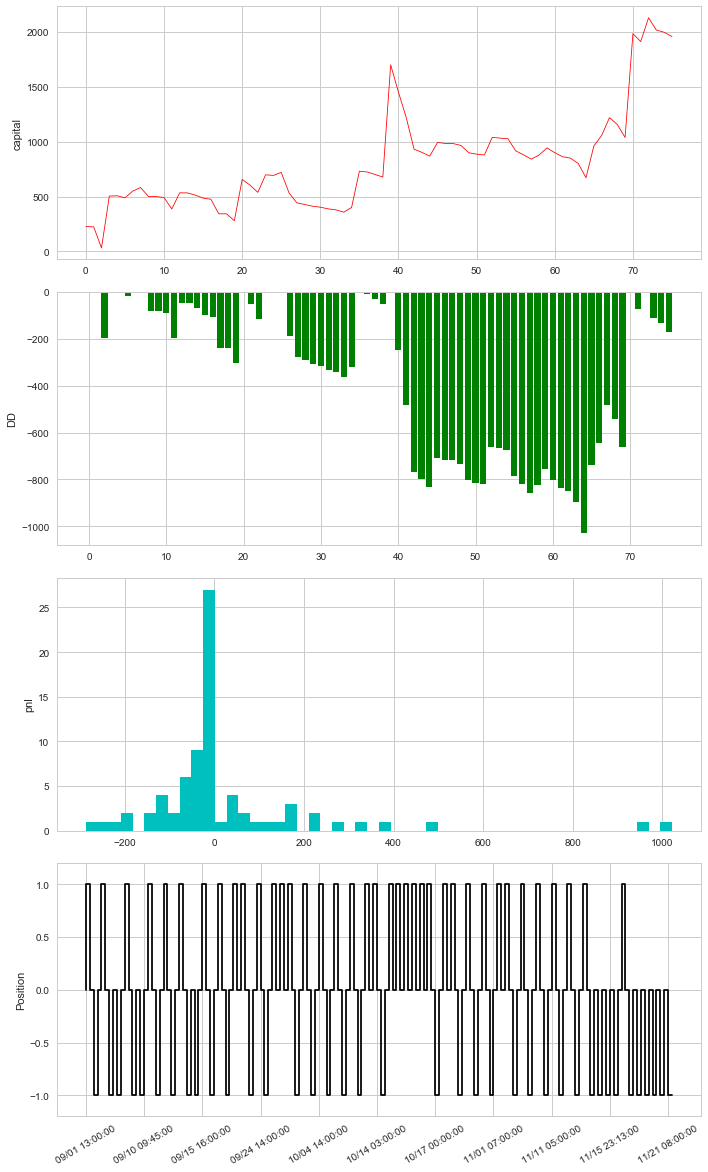

2018-11-27 19:01:30.086370	计算按日统计结果


(                netPnl  slippage  commission  turnover  tradeCount  \
 date                                                                 
 2018-09-01  108.980990     0.002    3.527010   7054.02           1   
 2018-09-02   47.710000     0.000    0.000000      0.00           0   
 2018-09-03   73.780000     0.000    0.000000      0.00           0   
 2018-09-04   83.629370     0.008   14.572630  29145.26           4   
 2018-09-05 -289.746605     0.004    7.042605  14085.21           2   
 2018-09-06  479.380090     0.004    6.465910  12931.82           2   
 2018-09-07  -39.899840     0.004    6.415840  12831.68           2   
 2018-09-08   -4.597450     0.004    6.403450  12806.90           2   
 2018-09-09   90.139955     0.002    3.168045   6336.09           1   
 2018-09-10   -9.518055     0.006    9.522055  19044.11           3   
 2018-09-11  -32.414110     0.004    6.260110  12520.22           2   
 2018-09-12  -36.835200     0.008   12.507200  25014.40           4   
 2018-

In [21]:
parameterDict = {'symbolList':['BTCUSDT:binance']}
runBacktesting(MultiFrameMaStrategy, parameterDict, '20180901 12:00', '20181121 12:00', 0.002, 5/10000)